## Model

In [1]:
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import keras
from keras import layers, ops
import matplotlib.pyplot as plt

SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

tf.config.run_functions_eagerly(True)

In [2]:
# retrieve所有video的名字

frames_path = 'data/frames/'
frames_path_normal = 'data/frames/Normal/'
frames_path_crash = 'data/frames/Crash/'

frames_name_normal = sorted([f for f in os.listdir(frames_path_normal)])
frames_name_crash = sorted([f for f in os.listdir(frames_path_crash)])

In [3]:
# 我只要50个video做train test split

frames_name_normal_valid = frames_name_normal[26:28]
frames_name_crash_valid = frames_name_normal[26:28]
frames_name_normal = frames_name_normal[1:26]
frames_name_crash = frames_name_crash[1:26]

In [4]:
# 三七分 train test split

train_normal, test_normal = train_test_split(frames_name_normal, \
                                     test_size=0.3, \
                                     random_state=42)

train_crash, test_crash = train_test_split(frames_name_crash, \
                                     test_size=0.3, \
                                     random_state=42)

In [18]:
# `##` --> Adjustable

# DATA
IMG_SIZE = 128  ## Image size (128, 128) in this case
CHAN_SIZE = 1   ## 1-GrayScale; 3-RGB - 结果一样（如果其它数值不变）
BATCH_SIZE = 8  ## 教程给的是 32 - 我没动过，可以调一下这个
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (50, IMG_SIZE, IMG_SIZE, CHAN_SIZE)
NUM_CLASSES = 2  ## 1-Crash; 0-Normal

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 10     ## 教程给的是100

# TUBELET EMBEDDING
PATCH_SIZE = (8,8,8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
EMBED_DIM = 64  ## Size of the feature vectors transformed from the input
NUM_HEADS = 8   ##
NUM_LAYERS = 4  ##

In [6]:
# Load data

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=CHAN_SIZE)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0 # Normalization
    return image

train_videos = []
test_videos = []
train_labels = []
test_labels = []

for t in train_normal:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_normal + t \
                                    + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_normal + t \
                                    + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    train_videos.append(video.numpy())
    train_labels.append(0)
    
for t in test_normal:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_normal + t \
                                    + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_normal + t \
                                    + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    test_videos.append(video.numpy())
    test_labels.append(0)

for t in train_crash:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t \
                                    + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t \
                                    + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    train_videos.append(video.numpy())
    train_labels.append(1)
    
for t in test_crash:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t \
                                    + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t \
                                    + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    test_videos.append(video.numpy())
    test_labels.append(1)

    
valid_videos = []
valid_labels = []
    
for t in frames_name_crash_valid:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t \
                                    + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t \
                                    + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    valid_videos.append(video.numpy())
    valid_labels.append(1)

for t in frames_name_normal_valid:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t \
                                    + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t \
                                    + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    valid_videos.append(video.numpy())
    valid_labels.append(0)

In [7]:
train_videos = np.asarray(train_videos)
test_videos = np.asarray(test_videos)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)
valid_videos = np.asarray(valid_videos)
valid_labels = np.asarray(valid_labels)

# print(len(train_videos), len(train_labels)) # 34, 34
# print(len(test_videos), len(test_labels)) # 16, 16

In [8]:
# Create Dataloader

def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label



def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare the dataloader."""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return dataloader


trainloader = prepare_dataloader(train_videos, train_labels, "train")
testloader = prepare_dataloader(test_videos, test_labels, "test")
validloader = prepare_dataloader(valid_videos, valid_labels, "valid")

In [9]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        
        # `projected_patches`
        # dividing the input into patches (determined by kernel_size and strides) 
        # and transforming each patch into an 64-dimensional embedding.
        
        projected_patches = self.projection(videos) 
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

In [10]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = ops.arange(0, num_tokens, 1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [11]:
class CustomMultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, key_dim, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim, dropout=dropout
        )

    def call(self, query, value):
        attention_output, attention_scores = self.attention(query, value, value)
        return attention_output, attention_scores

In [19]:
attention_scores_list = []

In [20]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=EMBED_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape) # (50, 128, 128, 1)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    # Each block consists of multi-head self-attention and multi-layer perceptron (MLP) layers
    for _ in range(transformer_layers):
        
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Allows the model to jointly attend to information from different representation 
        # subspaces at different positions.
        """
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)
        """
        attention_output, attention_scores = CustomMultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)
        
        global attention_scores_list
        attention_scores_list.append(attention_scores) # store scores

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        # The two fully-connected layers with GELU activation functions
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=ops.gelu),
                layers.Dense(units=embed_dim, activation=ops.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [21]:
def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=EMBED_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=EMBED_DIM)
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Train the model
    history = model.fit(trainloader, epochs=EPOCHS, validation_data=validloader)

    # Test the model
    loss, accuracy, top_5_accuracy = model.evaluate(testloader)
    
    print(f"----- Test accuracy: {accuracy * 100}%")

    return model, history


model, history = run_experiment()

# 试着调一下数值？Batch Size是不是太低了，会有很多 Noise
# 或者改一改 Model?
# 不过这些后期可以弄我先写个 Visualization

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.5006 - loss: 0.9240 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.2028 - val_top-5-accuracy: 1.0000
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.7023 - loss: 0.6546 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.9157 - val_top-5-accuracy: 1.0000
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - accuracy: 0.6348 - loss: 0.5610 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.8065 - val_top-5-accuracy: 1.0000
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8636 - loss: 0.3480 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.3248 - val_top-5-accuracy: 1.0000
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8242 - loss: 0.5139 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.1983 - val_top-5-accuracy: 1.0000
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8034 - loss: 0.4750 - top-5-accuracy: 1.0000 - v

## Visualization

In [35]:
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 50, 128,   │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tubelet_embedding_1 │ (None, 1536, 64)  │     32,832 │ input_layer_9[0]… │
│ (TubeletEmbedding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoder… │ (None, 1536, 64)  │     98,304 │ tubelet_embeddin… │
│ (PositionalEncoder) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_multi_head_… │ [(None, 1536,     │     16,640 │ layer_normalizat… │
│ (CustomMultiHeadAt… │ 64), (None, 8,    │            │ layer_normalizat… │
│                     │ 1536, 1536)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 1536, 64)  │          0 │ custom_multi_hea… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 1536, 64)  │     33,088 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 1536, 64)  │          0 │ sequential_8[0][… │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_multi_head_… │ [(None, 1536,     │     16,640 │ layer_normalizat… │
│ (CustomMultiHeadAt… │ 64), (None, 8,    │            │ layer_normalizat… │
│                     │ 1536, 1536)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 1536, 64)  │          0 │ custom_multi_hea… │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 1536, 64)  │     33,088 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 1536, 64)  │          0 │ sequential_9[0][… │
│                     │                   │            │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ add_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 1,593,800 (6.08 MB)

 Trainable params: 531,266 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,062,534 (4.05 MB)

In [37]:
model_predict_test = model.predict(testloader)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step


In [52]:
# 16 testing videos

for i in range(16):
    crash_conf = model_predict_test[i][0]
    normal_conf = model_predict_test[i][1]
    if (crash_conf > normal_conf):
        print("Prediction: Crash", crash_conf)
    else:
        print("Prediction: Normal", normal_conf)
    if (i < 8):
        print("Actual:     Crash", test_normal[i]+".mp4")
    else:
        print("Actual:     Normal", test_crash[abs(i-8)]+".mp4")
    print()

Prediction: Crash 0.9741699
Actual:     Crash 000009.mp4

Prediction: Crash 0.97586423
Actual:     Crash 000017.mp4

Prediction: Crash 0.52552426
Actual:     Crash 000001.mp4

Prediction: Crash 0.99709255
Actual:     Crash 000024.mp4

Prediction: Crash 0.5667927
Actual:     Crash 000012.mp4

Prediction: Crash 0.5622378
Actual:     Crash 000010.mp4

Prediction: Crash 0.9838781
Actual:     Crash 000014.mp4

Prediction: Normal 0.5480739
Actual:     Crash 000002.mp4

Prediction: Normal 0.5419006
Actual:     Normal 000009.mp4

Prediction: Normal 0.8019821
Actual:     Normal 000017.mp4

Prediction: Crash 0.6128242
Actual:     Normal 000001.mp4

Prediction: Normal 0.59649235
Actual:     Normal 000024.mp4

Prediction: Crash 0.53186613
Actual:     Normal 000012.mp4

Prediction: Crash 0.8470096
Actual:     Normal 000010.mp4

Prediction: Normal 0.68544394
Actual:     Normal 000014.mp4

Prediction: Crash 0.5380925
Actual:     Normal 000002.mp4



In [65]:
attention_scores_list

[<KerasTensor shape=(None, 8, 1536, 1536), dtype=float32, sparse=False, name=keras_tensor_111>,
 <KerasTensor shape=(None, 8, 1536, 1536), dtype=float32, sparse=False, name=keras_tensor_123>,
 <KerasTensor shape=(None, 8, 1536, 1536), dtype=float32, sparse=False, name=keras_tensor_135>,
 <KerasTensor shape=(None, 8, 1536, 1536), dtype=float32, sparse=False, name=keras_tensor_147>,
 <KerasTensor shape=(None, 8, 1536, 1536), dtype=float32, sparse=False, name=keras_tensor_159>,
 <KerasTensor shape=(None, 8, 1536, 1536), dtype=float32, sparse=False, name=keras_tensor_171>,
 <KerasTensor shape=(None, 8, 1536, 1536), dtype=float32, sparse=False, name=keras_tensor_183>,
 <KerasTensor shape=(None, 8, 1536, 1536), dtype=float32, sparse=False, name=keras_tensor_195>]

## 坏消息：attention_scores_list 是KerasTensor，不能convert成Numpy，所以目前不能visualize

In [74]:
## 1. Feature Heatmap using attention weights

# Attention Scores

# These scores represent how much each part of the input image (divided into patches) 
# attends to every other part (relations between layers)

# Transformers typically use multi-headed attention mechanisms where each head can potentially 
# focus on different features or parts of the image.

# To visualize these as heatmaps over the original image, 
#you will need to reshape these matrices back to the spatial dimensions of the image 
# and use interpolation techniques to upscale the coarse heatmap to the full resolution of the image.

# Visualize the Matrices: Use heatmaps to visualize each matrix. Areas of higher values (e.g., closer to 1)
# indicate stronger attention and can be represented with warmer colors.

# Calculate the average attention that each frame gives to every other frame. 
# This can help identify if certain frames are particularly influential or are being ignored.

# Look at the rows or columns that correspond to specific patches. 
# For instance, if a particular patch in Frame 1 consistently shows high attention values 
# across its row when looking at other frames, this indicates that the patch is of high interest 
# across the video.

# Patches are fixed-size, non-overlapping segments of the original image 
# (or frame in the case of video), each treated as a distinct element.

layer_idx = 0  # Choose which layer to visualize
head_idx = 0  # Choose which head to visualize
attention_matrix = attention_scores_list[layer_idx][:, head_idx, :, :]

# ** Cannot convert to numpy array **
#### attention_sample = attention_matrix[0].numpy()

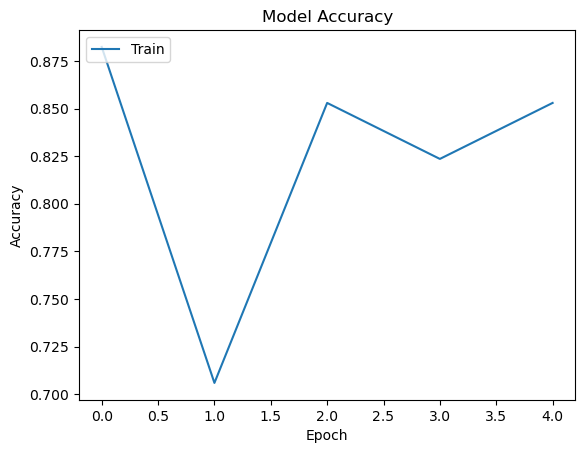

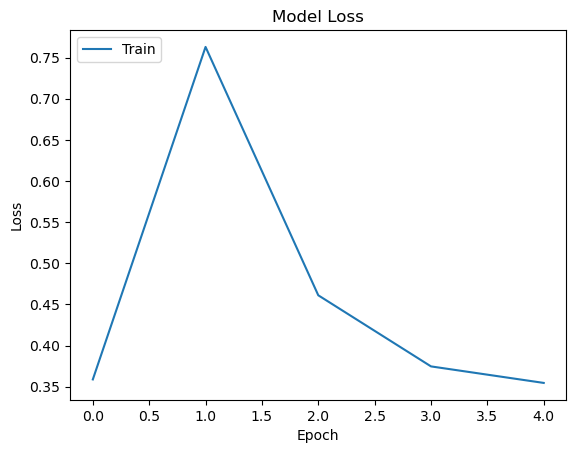

In [17]:
## 2. Accuracy and Loss

plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# 暂时没什么用捏

# weights_per_layer = []

# for layer in model.layers:
#     weights_per_layer.append(layer.get_weights())